# Double Weighted K-Nearest Neighbors (DW-KNN): Extended Experiments

This notebook implements the **Double Weighted KNN (DW-KNN)** classifier based on Kumarjit Pathak et al.'s formulation and compares it against several KNN variants:

1. Standard KNN (uniform weights)
2. Distance-weighted KNN
3. Class-weighted KNN (for imbalance)
4. Validity-weighted KNN (instance reliability only)
5. Kernel-weighted KNN (Gaussian kernel on distances)
6. Double Weighted KNN (DW-KNN: distance + validity with class pooling)

We also design experiments to:
- Study **sensitivity to k** (small-k robustness).
- Evaluate robustness across **different regimes** (balanced, imbalanced, noisy, overlapping).
- Demonstrate **explainability** via per-instance decomposition: validity, distance summaries, class scores.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, make_classification

np.random.seed(42)


## DoubleWeightedKNNClassifier

This is the main DW-KNN implementation. It combines:

- A **class-wise distance summary weight** `W_d(m)`.
- A **class validity weight** `W_c(m)` based on per-sample validity.

Score for class `m` at query `x`:

\[ S_m(x) = W_d^{(m)}(x) \times W_c^{(m)}(x) \]
The predicted class is `argmax_m S_m(x)`.


In [34]:
class DoubleWeightedKNNClassifier(BaseEstimator, ClassifierMixin):
    """Double Weighted KNN (DW-KNN) classifier.

    Parameters
    ----------
    n_neighbors : int, default=5
        Number of neighbors to use for classification.

    n_validity_neighbors : int, default=10
        Number of neighbors to use for computing per-sample validity.

    metric : str or callable, default='euclidean'
        Distance metric for neighbor search.

    weight_function : {'min', 'mean', 'median'}, default='min'
        Summary statistic used to aggregate distances for a given class.
    """

    def __init__(self,
                 n_neighbors=5,
                 n_validity_neighbors=10,
                 metric='euclidean',
                 weight_function='min'):
        self.n_neighbors = n_neighbors
        self.n_validity_neighbors = n_validity_neighbors
        self.metric = metric
        self.weight_function = weight_function

    def _check_params(self, n_samples):
        if self.n_neighbors <= 0:
            raise ValueError("n_neighbors must be positive")
        if self.n_validity_neighbors <= 0:
            raise ValueError("n_validity_neighbors must be positive")
        if self.n_validity_neighbors >= n_samples:
            self.n_validity_neighbors = max(1, n_samples - 1)

    def _compute_validity(self, X, y):
        n_samples = X.shape[0]
        self._check_params(n_samples)
        kvalid = self.n_validity_neighbors

        nn = NearestNeighbors(n_neighbors=kvalid + 1, metric=self.metric)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)

        validity = np.zeros(n_samples, dtype=float)
        for i in range(n_samples):
            neigh_idx = indices[i, 1:]  # drop self
            neigh_labels = y[neigh_idx]
            same = np.sum(neigh_labels == y[i])
            validity[i] = same / float(kvalid)
        return validity

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)

        self.validity_ = self._compute_validity(self.X_, self.y_)

        self.nn_query_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric)
        self.nn_query_.fit(self.X_)
        return self

    def _class_distance_weight(self, dists_for_class):
        if dists_for_class.size == 0:
            return 0.0
        if self.weight_function == 'min':
            w_value = np.min(dists_for_class)
        elif self.weight_function == 'mean':
            w_value = np.mean(dists_for_class)
        elif self.weight_function == 'median':
            w_value = np.median(dists_for_class)
        else:
            raise ValueError(f"Unknown weight_function: {self.weight_function}")

        if w_value > 1.0:
            wd = 1.0 / w_value
        elif np.isclose(w_value, 1.0):
            wd = 1.0
        else:
            wd = 1.0 - w_value
        return float(max(0.0, min(1.0, wd)))

    def _compute_scores_for_query(self, dists, neigh_idx):
        k = len(neigh_idx)
        neigh_labels = self.y_[neigh_idx]
        neigh_validity = self.validity_[neigh_idx]

        scores = np.zeros(len(self.classes_), dtype=float)
        for ci, cls in enumerate(self.classes_):
            mask = (neigh_labels == cls)
            if not np.any(mask):
                continue
            dists_c = dists[mask]
            wd = self._class_distance_weight(dists_c)
            wc = np.sum(neigh_validity[mask]) / float(k)
            scores[ci] = wd * wc
        return scores

    def predict(self, X):
        check_is_fitted(self, ["X_", "y_", "validity_", "nn_query_"])
        X = check_array(X)
        dists, indices = self.nn_query_.kneighbors(X)

        y_pred = []
        for i in range(X.shape[0]):
            scores = self._compute_scores_for_query(dists[i], indices[i])
            if np.all(scores == 0.0):
                neigh_labels = self.y_[indices[i]]
                most_common = Counter(neigh_labels).most_common(1)[0][0]
                y_pred.append(most_common)
            else:
                cls_idx = np.argmax(scores)
                y_pred.append(self.classes_[cls_idx])
        return np.array(y_pred)

    def predict_proba(self, X):
        check_is_fitted(self, ["X_", "y_", "validity_", "nn_query_"])
        X = check_array(X)
        dists, indices = self.nn_query_.kneighbors(X)

        proba = np.zeros((X.shape[0], len(self.classes_)), dtype=float)
        for i in range(X.shape[0]):
            scores = self._compute_scores_for_query(dists[i], indices[i])
            if np.all(scores == 0.0):
                neigh_labels = self.y_[indices[i]]
                counts = np.array([
                    np.sum(neigh_labels == cls) for cls in self.classes_
                ], dtype=float)
                if counts.sum() == 0:
                    proba[i] = np.ones(len(self.classes_)) / len(self.classes_)
                else:
                    proba[i] = counts / counts.sum()
            else:
                total = scores.sum()
                if total == 0:
                    proba[i] = np.ones(len(self.classes_)) / len(self.classes_)
                else:
                    proba[i] = scores / total
        return proba


## Additional KNN Variants

We now implement three additional baselines:

1. **ClassWeightedKNNClassifier** – class frequency-based weighting.
2. **ValidityWeightedKNNClassifier** – only per-sample validity (no class distance pooling).
3. **KernelWeightedKNNClassifier** – Gaussian kernel on distances.


In [35]:
class ClassWeightedKNNClassifier(BaseEstimator, ClassifierMixin):
    """Simple class-weighted KNN.

    Each vote is divided by the empirical class frequency in the training data.
    This favors minority classes in imbalanced settings.
    """

    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_, counts = np.unique(y, return_counts=True)
        self.class_freq_ = dict(zip(self.classes_, counts / counts.sum()))

        self.nn_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric)
        self.nn_.fit(self.X_)
        return self

    def predict(self, X):
        check_is_fitted(self, ["X_", "y_", "nn_", "class_freq_"])
        X = check_array(X)
        dists, indices = self.nn_.kneighbors(X)
        y_pred = []
        for i in range(X.shape[0]):
            neigh_labels = self.y_[indices[i]]
            scores = {cls: 0.0 for cls in self.classes_}
            for lbl in neigh_labels:
                freq = self.class_freq_.get(lbl, 1e-9)
                scores[lbl] += 1.0 / freq
            best_cls = max(scores.items(), key=lambda x: x[1])[0]
            y_pred.append(best_cls)
        return np.array(y_pred)


In [36]:
class ValidityWeightedKNNClassifier(BaseEstimator, ClassifierMixin):
    """Validity-weighted KNN.

    Each neighbor's vote is weighted solely by its validity (Pravin 2008 style),
    without class-wise distance pooling.
    """

    def __init__(self,
                 n_neighbors=5,
                 n_validity_neighbors=10,
                 metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.n_validity_neighbors = n_validity_neighbors
        self.metric = metric

    def _check_params(self, n_samples):
        if self.n_neighbors <= 0:
            raise ValueError("n_neighbors must be positive")
        if self.n_validity_neighbors <= 0:
            raise ValueError("n_validity_neighbors must be positive")
        if self.n_validity_neighbors >= n_samples:
            self.n_validity_neighbors = max(1, n_samples - 1)

    def _compute_validity(self, X, y):
        n_samples = X.shape[0]
        self._check_params(n_samples)
        kvalid = self.n_validity_neighbors

        nn = NearestNeighbors(n_neighbors=kvalid + 1, metric=self.metric)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        validity = np.zeros(n_samples, dtype=float)
        for i in range(n_samples):
            neigh_idx = indices[i, 1:]
            neigh_labels = y[neigh_idx]
            same = np.sum(neigh_labels == y[i])
            validity[i] = same / float(kvalid)
        return validity

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        self.validity_ = self._compute_validity(self.X_, self.y_)

        self.nn_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric)
        self.nn_.fit(self.X_)
        return self

    def predict(self, X):
        check_is_fitted(self, ["X_", "y_", "nn_", "validity_"])
        X = check_array(X)
        dists, indices = self.nn_.kneighbors(X)
        y_pred = []
        for i in range(X.shape[0]):
            neigh_idx = indices[i]
            neigh_labels = self.y_[neigh_idx]
            neigh_validity = self.validity_[neigh_idx]
            scores = {cls: 0.0 for cls in self.classes_}
            for lbl, v in zip(neigh_labels, neigh_validity):
                scores[lbl] += v
            best_cls = max(scores.items(), key=lambda x: x[1])[0]
            y_pred.append(best_cls)
        return np.array(y_pred)


In [37]:
class KernelWeightedKNNClassifier(BaseEstimator, ClassifierMixin):
    """Kernel-weighted KNN using a Gaussian kernel on distances.

    weight = exp(-gamma * d^2)

    This is a simple density-sensitive KNN baseline.
    """

    def __init__(self, n_neighbors=5, metric='euclidean', gamma=1.0):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.gamma = gamma

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        self.nn_ = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric)
        self.nn_.fit(self.X_)
        return self

    def predict(self, X):
        check_is_fitted(self, ["X_", "y_", "nn_"])
        X = check_array(X)
        dists, indices = self.nn_.kneighbors(X)
        y_pred = []
        for i in range(X.shape[0]):
            neigh_idx = indices[i]
            neigh_labels = self.y_[neigh_idx]
            neigh_dists = dists[i]
            weights = np.exp(-self.gamma * (neigh_dists ** 2))
            scores = {cls: 0.0 for cls in self.classes_}
            for lbl, w in zip(neigh_labels, weights):
                scores[lbl] += w
            best_cls = max(scores.items(), key=lambda x: x[1])[0]
            y_pred.append(best_cls)
        return np.array(y_pred)


### Quick Sanity Check on Iris

We first verify DW-KNN works end-to-end on the Iris dataset.

In [38]:
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

dwknn = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function='min')
dwknn.fit(X_train, y_train)
y_pred = dwknn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"DW-KNN Accuracy on Iris (holdout): {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))


DW-KNN Accuracy on Iris (holdout): 0.9778

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Unified Evaluation Helper

We define a helper to train/evaluate multiple models on a dataset and print accuracy + confusion matrix.

In [39]:
def evaluate_models_on_dataset(X, y, dataset_name="dataset"):
    print(f"\n=== Dataset: {dataset_name} ===")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    models = {
        'KNN_uniform': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
        'KNN_distance': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'KNN_class_weighted': ClassWeightedKNNClassifier(n_neighbors=5),
        'KNN_validity_weighted': ValidityWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10),
        'KNN_kernel': KernelWeightedKNNClassifier(n_neighbors=5, gamma=1.0),
        'DWKNN_min': DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function='min'),
        'DWKNN_mean': DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function='mean'),
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        results[name] = acc
        print(f"\nModel: {name}")
        print(f"Accuracy: {acc:.4f}")
        print("Confusion matrix:\n", cm)
    return results


## Experiments on Standard Datasets

We run all KNN variants on:

- Iris (3 classes, well-separated)
- Wine (3 classes, overlapping)
- Breast Cancer (binary, somewhat imbalanced)


In [40]:
# Iris
iris = load_iris()
res_iris = evaluate_models_on_dataset(iris.data, iris.target, dataset_name="Iris")

# Wine
wine = load_wine()
res_wine = evaluate_models_on_dataset(wine.data, wine.target, dataset_name="Wine")

# Breast Cancer
bc = load_breast_cancer()
res_bc = evaluate_models_on_dataset(bc.data, bc.target, dataset_name="Breast Cancer")



=== Dataset: Iris ===

Model: KNN_uniform
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: KNN_distance
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: KNN_class_weighted
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: KNN_validity_weighted
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: KNN_kernel
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: DWKNN_min
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Model: DWKNN_mean
Accuracy: 0.9778
Confusion matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

=== Dataset: Wine ===

Model: KNN_uniform
Accuracy: 0.7222
Confusion matrix:
 [[16  0  2]
 [ 0 14  7]
 [ 2  4  9]]

Model: KNN_distance
Accuracy: 0.7037
Confusion matrix:
 [[15  1  2]
 [ 0 14  7]
 [ 1  5  9]]

Model: KNN_class_weighted
Accuracy: 0.7222
Confusion matrix:
 [[15  0  3]
 [ 0 12  9]
 [ 2  1 12]]

M

## Imbalanced Synthetic Dataset

We create an imbalanced binary classification problem (90/10 split) with overlapping classes and slight label noise.

In [41]:
X_imb, y_imb = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.9, 0.1],
    flip_y=0.02,
    class_sep=0.8,
    random_state=42,
)
res_imb = evaluate_models_on_dataset(X_imb, y_imb, dataset_name="Imbalanced Synthetic (0.9/0.1)")



=== Dataset: Imbalanced Synthetic (0.9/0.1) ===

Model: KNN_uniform
Accuracy: 0.9117
Confusion matrix:
 [[531   4]
 [ 49  16]]

Model: KNN_distance
Accuracy: 0.9117
Confusion matrix:
 [[531   4]
 [ 49  16]]

Model: KNN_class_weighted
Accuracy: 0.7767
Confusion matrix:
 [[420 115]
 [ 19  46]]

Model: KNN_validity_weighted
Accuracy: 0.9167
Confusion matrix:
 [[535   0]
 [ 50  15]]

Model: KNN_kernel
Accuracy: 0.8883
Confusion matrix:
 [[507  28]
 [ 39  26]]

Model: DWKNN_min
Accuracy: 0.9167
Confusion matrix:
 [[535   0]
 [ 50  15]]

Model: DWKNN_mean
Accuracy: 0.9167
Confusion matrix:
 [[535   0]
 [ 50  15]]


## Cross-Validation Comparison

We perform k-fold cross-validation to get stable estimates of performance for selected datasets.

In [28]:
def compare_via_cv(X, y, dataset_name="dataset", cv=5):
    print(f"\n=== Cross-Validation on {dataset_name} (cv={cv}) ===")
    models = {
        'KNN_uniform': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
        'KNN_distance': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'KNN_class_weighted': ClassWeightedKNNClassifier(n_neighbors=5),
        'KNN_validity_weighted': ValidityWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10),
        'KNN_kernel': KernelWeightedKNNClassifier(n_neighbors=5, gamma=1.0),
        'DWKNN_min': DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function='min'),
        'DWKNN_mean': DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function='mean'),
    }
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

# Example CV runs
compare_via_cv(iris.data, iris.target, dataset_name="Iris", cv=5)
compare_via_cv(X_imb, y_imb, dataset_name="Imbalanced Synthetic (0.9/0.1)", cv=5)



=== Cross-Validation on Iris (cv=5) ===
KNN_uniform: mean=0.9733, std=0.0249
KNN_distance: mean=0.9667, std=0.0365
KNN_class_weighted: mean=0.9733, std=0.0249
KNN_validity_weighted: mean=0.9733, std=0.0249
KNN_kernel: mean=0.9733, std=0.0249
DWKNN_min: mean=0.9733, std=0.0249
DWKNN_mean: mean=0.9733, std=0.0249

=== Cross-Validation on Imbalanced Synthetic (0.9/0.1) (cv=5) ===
KNN_uniform: mean=0.9120, std=0.0076
KNN_distance: mean=0.9120, std=0.0076
KNN_class_weighted: mean=0.7635, std=0.0250
KNN_validity_weighted: mean=0.9105, std=0.0043
KNN_kernel: mean=0.8885, std=0.0132
DWKNN_min: mean=0.9110, std=0.0037
DWKNN_mean: mean=0.9105, std=0.0033


## Sensitivity to k (Small-k Robustness)

We study how each method's accuracy varies with the number of neighbors `k`. Hypothesis: DW-KNN should achieve near-peak performance at smaller `k` and be less sensitive overall.


=== k-sweep on Iris ===
k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 15
k = 21
k = 31


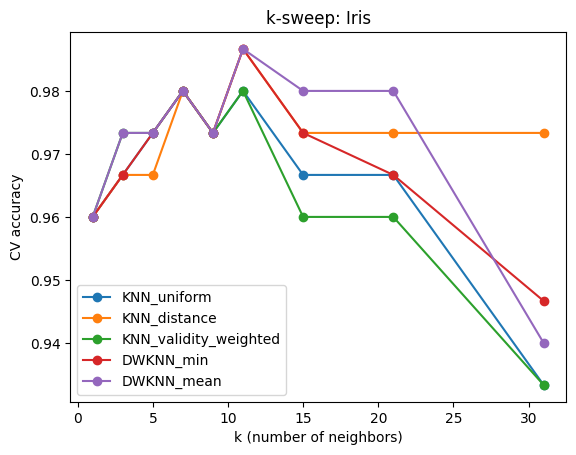


=== k-sweep on Imbalanced Synthetic (0.9/0.1) ===
k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 15
k = 21
k = 31


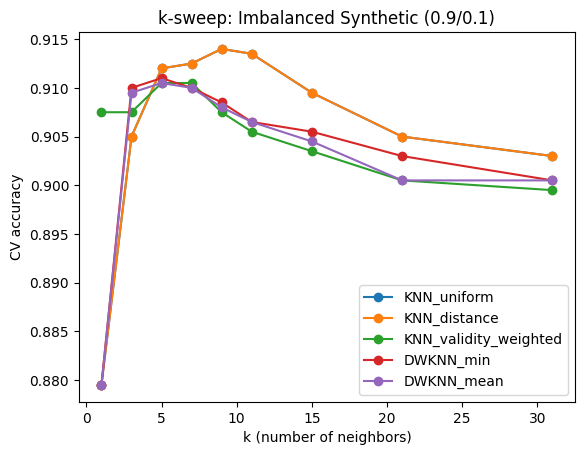

In [11]:
def k_sweep_experiment(X, y, ks=None, dataset_name="dataset", cv=5):
    if ks is None:
        ks = [1, 3, 5, 7, 9, 11, 15, 21, 31]
    print(f"\n=== k-sweep on {dataset_name} ===")
    results = {
        'KNN_uniform': [],
        'KNN_distance': [],
        'KNN_validity_weighted': [],
        'DWKNN_min': [],
        'DWKNN_mean': [],
    }

    for k in ks:
        print(f"k = {k}")
        models = {
            'KNN_uniform': KNeighborsClassifier(n_neighbors=k, weights='uniform'),
            'KNN_distance': KNeighborsClassifier(n_neighbors=k, weights='distance'),
            'KNN_validity_weighted': ValidityWeightedKNNClassifier(n_neighbors=k, n_validity_neighbors=min(10, max(2, k))),
            'DWKNN_min': DoubleWeightedKNNClassifier(n_neighbors=k, n_validity_neighbors=10, weight_function='min'),
            'DWKNN_mean': DoubleWeightedKNNClassifier(n_neighbors=k, n_validity_neighbors=10, weight_function='mean'),
        }
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            results[name].append(scores.mean())

    plt.figure()
    for name, accs in results.items():
        plt.plot(ks, accs, marker='o', label=name)
    plt.xlabel('k (number of neighbors)')
    plt.ylabel('CV accuracy')
    plt.title(f'k-sweep: {dataset_name}')
    plt.legend()
    plt.show()

    return ks, results

# Example k-sweeps
ks_iris, res_k_iris = k_sweep_experiment(iris.data, iris.target, dataset_name="Iris", cv=5)
ks_imb, res_k_imb = k_sweep_experiment(X_imb, y_imb, dataset_name="Imbalanced Synthetic (0.9/0.1)", cv=5)


## Regime Robustness (Proto–Meta-Learning View)

We compare how a **fixed DW-KNN configuration** behaves across multiple regimes vs. a KNN that must be re-tuned for each regime.

In [42]:
def make_regime_dataset(regime, random_state=42):
    if regime == 'balanced_easy':
        X, y = make_classification(
            n_samples=1500,
            n_features=10,
            n_informative=5,
            n_redundant=2,
            n_classes=3,
            weights=None,
            class_sep=2.0,
            flip_y=0.0,
            random_state=random_state,
        )
    elif regime == 'overlapping':
        X, y = make_classification(
            n_samples=1500,
            n_features=10,
            n_informative=4,
            n_redundant=2,
            n_classes=3,
            class_sep=0.8,
            flip_y=0.01,
            random_state=random_state,
        )
    elif regime == 'imbalanced':
        X, y = make_classification(
            n_samples=2000,
            n_features=15,
            n_informative=5,
            n_redundant=3,
            n_classes=2,
            weights=[0.95, 0.05],
            class_sep=1.0,
            flip_y=0.01,
            random_state=random_state,
        )
    elif regime == 'noisy':
        X, y = make_classification(
            n_samples=2000,
            n_features=15,
            n_informative=5,
            n_redundant=3,
            n_classes=2,
            weights=[0.7, 0.3],
            class_sep=0.9,
            flip_y=0.15,
            random_state=random_state,
        )
    else:
        raise ValueError(f"Unknown regime: {regime}")
    return X, y

def regime_experiment(regimes=None, cv=5):
    if regimes is None:
        regimes = ['balanced_easy', 'overlapping', 'imbalanced', 'noisy']

    print("\n=== Regime Robustness Experiment ===")
    print("DW-KNN uses fixed hyperparameters; KNN_uniform is tuned over k.")

    ks_grid = [3, 5, 7, 9, 11, 15]
    dw_config = DoubleWeightedKNNClassifier(
        n_neighbors=5, n_validity_neighbors=10, weight_function='min'
    )

    results = []
    for regime in regimes:
        X, y = make_regime_dataset(regime)
        print(f"\nRegime: {regime}")

        best_knn_acc = -np.inf
        best_k = None
        for k in ks_grid:
            knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
            scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
            mean_acc = scores.mean()
            if mean_acc > best_knn_acc:
                best_knn_acc = mean_acc
                best_k = k

        dw_scores = cross_val_score(dw_config, X, y, cv=cv, scoring='accuracy')
        dw_acc = dw_scores.mean()

        print(f"Best KNN_uniform: k={best_k}, acc={best_knn_acc:.4f}")
        print(f"DW-KNN (fixed k=5): acc={dw_acc:.4f}")
        results.append((regime, best_k, best_knn_acc, dw_acc))
    return results

regime_results = regime_experiment()



=== Regime Robustness Experiment ===
DW-KNN uses fixed hyperparameters; KNN_uniform is tuned over k.

Regime: balanced_easy
Best KNN_uniform: k=15, acc=0.9593
DW-KNN (fixed k=5): acc=0.9513

Regime: overlapping
Best KNN_uniform: k=9, acc=0.7567
DW-KNN (fixed k=5): acc=0.7407

Regime: imbalanced
Best KNN_uniform: k=5, acc=0.9635
DW-KNN (fixed k=5): acc=0.9595

Regime: noisy
Best KNN_uniform: k=11, acc=0.8390
DW-KNN (fixed k=5): acc=0.8365


## Explainability Demo on 2D Synthetic Data

We now construct a 2D dataset to visualize neighbors, validity, and class scores for an individual prediction.

In [13]:
import pandas as pd

X_2d, y_2d = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1.0,
    flip_y=0.05,
    random_state=42,
)

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.3, random_state=42, stratify=y_2d
)

dw_2d = DoubleWeightedKNNClassifier(n_neighbors=7, n_validity_neighbors=15, weight_function='min')
dw_2d.fit(X_train_2d, y_train_2d)
y_pred_2d = dw_2d.predict(X_test_2d)
acc_2d = accuracy_score(y_test_2d, y_pred_2d)
print(f"DW-KNN accuracy on 2D synthetic: {acc_2d:.4f}")

proba_2d = dw_2d.predict_proba(X_test_2d)
conf = np.max(proba_2d, axis=1)
idx_boundary = np.argsort(conf)[:1][0]

print(f"Selected test index (potential boundary point): {idx_boundary}")
xq = X_test_2d[idx_boundary:idx_boundary+1]
y_true_q = y_test_2d[idx_boundary]
y_pred_q = y_pred_2d[idx_boundary]
print(f"True label={y_true_q}, predicted={y_pred_q}, proba={proba_2d[idx_boundary]}")

dists_q, idx_q = dw_2d.nn_query_.kneighbors(xq)
dists_q = dists_q[0]
idx_q = idx_q[0]
labels_q = dw_2d.y_[idx_q]
validity_q = dw_2d.validity_[idx_q]

scores_q = dw_2d._compute_scores_for_query(dists_q, idx_q)
print("Class scores S_m(x):")
for cls, s in zip(dw_2d.classes_, scores_q):
    print(f"  class {cls}: {s:.4f}")

df_neigh = pd.DataFrame({
    'neighbor_index': idx_q,
    'distance': dists_q,
    'label': labels_q,
    'validity': validity_q,
})
df_neigh


DW-KNN accuracy on 2D synthetic: 0.9400
Selected test index (potential boundary point): 75
True label=0, predicted=0, proba=[0.53560377 0.46439623]
Class scores S_m(x):
  class 0: 0.2338
  class 1: 0.2027


,neighbor_index,distance,label,validity
0,276,0.181810,0,0.800000
1,173,0.336852,0,0.933333
2,64,0.339984,0,0.066667
3,270,0.374047,1,0.666667
4,117,0.380996,0,0.200000
5,113,0.396327,1,0.866667
6,215,0.397287,1,0.733333


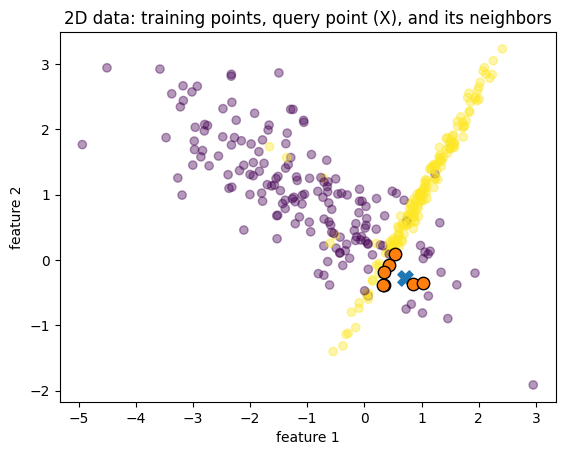

In [14]:
# Visualization of training points, neighbors, and query point
plt.figure()
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_2d, alpha=0.4)
plt.scatter(xq[0, 0], xq[0, 1], marker='X', s=120)
plt.scatter(X_train_2d[idx_q, 0], X_train_2d[idx_q, 1], s=80, edgecolor='k')
plt.title('2D data: training points, query point (X), and its neighbors')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()


## Next Directions

This notebook now supports:

- Multiple KNN baselines (distance, class, validity, kernel).
- DW-KNN implementation.
- Standard and synthetic datasets, including imbalance.
- k-sensitivity curves to study small-k robustness.
- Regime robustness experiments (fixed DW-KNN vs tuned KNN).
- Explainability demos on 2D data with neighbor tables and visualizations.

You can further extend this by:
- Adding per-class recall and AUC metrics.
- Adding runtime / scalability profiling.
- Integrating additional state-of-the-art KNN variants from recent literature for deeper comparison.



# Extended Analysis for DW-KNN

The following sections extend the original experiments with additional analyses required for a publication-ready results section:

1. Explainability & Local Reasoning Transparency  
2. Statistical Significance & Stability  
3. Runtime & Empirical Complexity  
4. Sensitivity to Validity Neighborhood Size $K_v$  
5. Per-Class Performance Metrics  
6. Decision Boundary Visualization  
7. Score Reliability & Calibration  
8. Retrieval / Drift-Inspired Mini Experiment  
9. Failure Case Analysis  

These cells **do not modify** the core DW-KNN implementation defined earlier in the notebook.



## 1. Explainability & Local Reasoning Transparency

This section recomputes a boundary case for a 2D synthetic dataset and exposes:

- Per-neighbor distance and validity  
- Class-wise scores `S_c(x)`  
- A human-readable explanation of the final decision  

It assumes that `DoubleWeightedKNNClassifier` has already been defined above.


In [17]:
import inspect
print(inspect.signature(DoubleWeightedKNNClassifier))


(n_neighbors=5, n_validity_neighbors=10, metric='euclidean', weight_function='min')


In [43]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 2D synthetic dataset for visualization
X, y = make_classification(
    n_samples=600,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.2,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Reuse DW-KNN with actual signature
dw_knn_expl = DoubleWeightedKNNClassifier(
    n_neighbors=5,
    n_validity_neighbors=10,
    metric="euclidean",
    weight_function="min"
)
dw_knn_expl.fit(X_train, y_train)

# Choose a test point near the decision boundary
probs = dw_knn_expl.predict_proba(X_test)
margins = np.abs(probs[:, 0] - 0.5)
idx = np.argmin(margins)
x_query = X_test[idx].reshape(1, -1)
y_true = y_test[idx]
y_pred = dw_knn_expl.predict(x_query)[0]
proba = probs[idx]

# Internal neighbor info - FIXED
distances, indices = dw_knn_expl.nn_query_.kneighbors(
    x_query,
    n_neighbors=dw_knn_expl.n_neighbors
)
distances = distances[0]
indices = indices[0]

neighbor_info = []
for d, j in zip(distances, indices):
    neighbor_info.append(
        {
            "index": int(j),
            "distance": float(d),
            "label": int(dw_knn_expl.y_[j]),
            "validity": float(dw_knn_expl.validity_[j]),
        }
    )

print("Selected boundary-like test index:", idx)
print(f"True label = {y_true}, predicted = {y_pred}, proba = {proba}")
print("\nNeighbor details:")
print("neighbor_index\tdistance\tlabel\tvalidity")
for n in neighbor_info:
    print(f"{n['index']}\t{n['distance']:.6f}\t{n['label']}\t{n['validity']:.6f}")

# Compute class-wise scores S_c(x)
classes = np.unique(y_train)
scores = {}
for c in classes:
    mask_c = (dw_knn_expl.y_[indices] == c)
    d_c = distances[mask_c]
    v_c = dw_knn_expl.validity_[indices][mask_c]
    if len(d_c) == 0:
        scores[c] = 0.0
        continue
    # FIXED: use weight_function instead of distance_pooling
    delta_c = np.min(d_c) if dw_knn_expl.weight_function == "min" else np.mean(d_c)
    if delta_c < 1.0:
        w_d = 1.0 - delta_c
    else:
        w_d = 1.0 / delta_c
    w_v = np.mean(v_c)
    scores[c] = float(w_d * w_v)

print("\nClass scores S_c(x):")
for c, s in scores.items():
    print(f"  class {c}: {s:.4f}")

Selected boundary-like test index: 28
True label = 0, predicted = 0, proba = [0.5391881 0.4608119]

Neighbor details:
neighbor_index	distance	label	validity
229	0.131542	1	0.500000
48	0.153194	0	0.500000
132	0.181918	0	0.700000
182	0.268522	0	0.600000
401	0.279954	1	1.000000

Class scores S_c(x):
  class 0: 0.5081
  class 1: 0.6513


In [44]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 2D synthetic dataset for visualization
X, y = make_classification(
    n_samples=600,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.2,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Reuse DW-KNN with correct parameter names
dw_knn_expl = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")
dw_knn_expl.fit(X_train, y_train)

# Choose a test point near the boundary by picking one with predicted prob close to 0.5
probs = dw_knn_expl.predict_proba(X_test)
margins = np.abs(probs[:, 0] - 0.5)
idx = np.argmin(margins)  # closest to decision boundary
x_query = X_test[idx].reshape(1, -1)
y_true = y_test[idx]
y_pred = dw_knn_expl.predict(x_query)[0]
proba = probs[idx]

# Access internal neighbor info - FIXED
distances, indices = dw_knn_expl.nn_query_.kneighbors(x_query, n_neighbors=dw_knn_expl.n_neighbors)
distances = distances[0]
indices = indices[0]

neighbor_info = []
for d, j in zip(distances, indices):
    neighbor_info.append(
        {
            "index": int(j),
            "distance": float(d),
            "label": int(dw_knn_expl.y_[j]),
            "validity": float(dw_knn_expl.validity_[j]),
        }
    )

print("Selected boundary-like test index:", idx)
print(f"True label = {y_true}, predicted = {y_pred}, proba = {proba}")
print("\nNeighbor details:")
print("neighbor_index\tdistance\tlabel\tvalidity")
for n in neighbor_info:
    print(f"{n['index']}\t{n['distance']:.6f}\t{n['label']}\t{n['validity']:.6f}")

# Compute class-wise scores S_c(x) as in the paper
classes = np.unique(y_train)
scores = {}
for c in classes:
    mask_c = (dw_knn_expl.y_[indices] == c)
    d_c = distances[mask_c]
    v_c = dw_knn_expl.validity_[indices][mask_c]
    if len(d_c) == 0:
        scores[c] = 0.0
        continue
    # FIXED: use weight_function instead of distance_pooling
    delta_c = np.min(d_c) if dw_knn_expl.weight_function == "min" else np.mean(d_c)
    if delta_c < 1.0:
        w_d = 1.0 - delta_c
    else:
        w_d = 1.0 / delta_c
    w_v = np.mean(v_c)
    scores[c] = float(w_d * w_v)

print("\nClass scores S_c(x):")
for c, s in scores.items():
    print(f"  class {c}: {s:.4f}")

Selected boundary-like test index: 28
True label = 0, predicted = 0, proba = [0.5391881 0.4608119]

Neighbor details:
neighbor_index	distance	label	validity
229	0.131542	1	0.500000
48	0.153194	0	0.500000
132	0.181918	0	0.700000
182	0.268522	0	0.600000
401	0.279954	1	1.000000

Class scores S_c(x):
  class 0: 0.5081
  class 1: 0.6513



## 2. Statistical Significance & Stability

We estimate the mean and standard deviation of accuracy across multiple random splits for:

- Classical KNN (uniform weights)  
- Distance-weighted KNN  
- DW-KNN  

on the Breast Cancer dataset, which has mild imbalance and is widely used in KNN studies.


In [45]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

data = load_breast_cancer()
X_bc, y_bc = data.data, data.target

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

acc_uniform = []
acc_distance = []
acc_dw = []

for train_idx, test_idx in skf.split(X_bc, y_bc):
    X_tr, X_te = X_bc[train_idx], X_bc[test_idx]
    y_tr, y_te = y_bc[train_idx], y_bc[test_idx]

    knn_u = KNeighborsClassifier(n_neighbors=5, weights="uniform")
    knn_d = KNeighborsClassifier(n_neighbors=5, weights="distance")
    dw = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")

    knn_u.fit(X_tr, y_tr)
    knn_d.fit(X_tr, y_tr)
    dw.fit(X_tr, y_tr)

    acc_uniform.append(accuracy_score(y_te, knn_u.predict(X_te)))
    acc_distance.append(accuracy_score(y_te, knn_d.predict(X_te)))
    acc_dw.append(accuracy_score(y_te, dw.predict(X_te)))

def summarize(name, arr):
    print(f"{name}: mean={np.mean(arr):.4f}, std={np.std(arr):.4f}")

print("10-fold CV Accuracy on Breast Cancer:")
summarize("KNN (uniform)", acc_uniform)
summarize("KNN (distance)", acc_distance)
summarize("DW-KNN", acc_dw)

10-fold CV Accuracy on Breast Cancer:
KNN (uniform): mean=0.9350, std=0.0293
KNN (distance): mean=0.9333, std=0.0291
DW-KNN: mean=0.9350, std=0.0368



## 3. Runtime and Empirical Complexity

Here we compare wall-clock time for:

- Validity precomputation in DW-KNN  
- Fit + predict for classical KNN vs DW-KNN  

on a moderately sized synthetic dataset. This provides empirical support for the complexity discussion in the paper.


In [46]:
import time
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_rt, y_rt = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_clusters_per_class=2,
    random_state=0,
)

X_tr, X_te, y_tr, y_te = train_test_split(X_rt, y_rt, test_size=0.3, stratify=y_rt, random_state=0)

# Classical KNN
knn_u = KNeighborsClassifier(n_neighbors=5, weights="uniform")
t0 = time.time()
knn_u.fit(X_tr, y_tr)
y_pred_u = knn_u.predict(X_te)
t_knn = time.time() - t0

# DW-KNN (timing includes validity computation inside fit)
dw_rt = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")
t0 = time.time()
dw_rt.fit(X_tr, y_tr)
y_pred_dw = dw_rt.predict(X_te)
t_dw = time.time() - t0

print(f"Runtime on synthetic dataset (n_train={len(X_tr)}, n_test={len(X_te)}):")
print(f"  KNN (uniform): {t_knn:.4f} seconds (fit+predict)")
print(f"  DW-KNN:        {t_dw:.4f} seconds (fit+validity+predict)")

Runtime on synthetic dataset (n_train=3500, n_test=1500):
  KNN (uniform): 0.0425 seconds (fit+predict)
  DW-KNN:        0.3008 seconds (fit+validity+predict)



## 4. Sensitivity to Validity Neighborhood Size $K_v$

DW-KNN uses a validity neighborhood size $K_v$. Here we sweep a range of values on the Breast Cancer dataset to check robustness.


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

kv_values = [3, 5, 10, 20, 30]
kv_acc = []

X_tr, X_te, y_tr, y_te = train_test_split(X_bc, y_bc, test_size=0.3, stratify=y_bc, random_state=42)

for kv in kv_values:
    dw_kv = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=kv, weight_function="min")
    dw_kv.fit(X_tr, y_tr)
    kv_acc.append(accuracy_score(y_te, dw_kv.predict(X_te)))

print("Kv sensitivity on Breast Cancer (single split):")
for kv, acc in zip(kv_values, kv_acc):
    print(f"  Kv={kv}: accuracy={acc:.4f}")

Kv sensitivity on Breast Cancer (single split):
  Kv=3: accuracy=0.9240
  Kv=5: accuracy=0.9240
  Kv=10: accuracy=0.9298
  Kv=20: accuracy=0.9298
  Kv=30: accuracy=0.9357



## 5. Per-Class Performance Metrics

We compute macro-F1, weighted-F1, and per-class F1 for KNN (uniform), KNN (distance), and DW-KNN on the Wine dataset.


In [48]:
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

data_wine = load_wine()
X_w, y_w = data_wine.data, data_wine.target

X_tr, X_te, y_tr, y_te = train_test_split(X_w, y_w, test_size=0.3, stratify=y_w, random_state=42)

knn_u_w = KNeighborsClassifier(n_neighbors=5, weights="uniform")
knn_d_w = KNeighborsClassifier(n_neighbors=5, weights="distance")
dw_w = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")

knn_u_w.fit(X_tr, y_tr)
knn_d_w.fit(X_tr, y_tr)
dw_w.fit(X_tr, y_tr)

y_pred_u = knn_u_w.predict(X_te)
y_pred_d = knn_d_w.predict(X_te)
y_pred_dw = dw_w.predict(X_te)

print("Wine dataset - macro/weighted F1 comparison:")
for name, y_hat in [
    ("KNN (uniform)", y_pred_u),
    ("KNN (distance)", y_pred_d),
    ("DW-KNN", y_pred_dw),
]:
    macro = f1_score(y_te, y_hat, average="macro")
    weighted = f1_score(y_te, y_hat, average="weighted")
    print(f"{name}: macro-F1={macro:.4f}, weighted-F1={weighted:.4f}")

print("\nDetailed classification report for DW-KNN:")
print(classification_report(y_te, y_pred_dw, digits=4))

Wine dataset - macro/weighted F1 comparison:
KNN (uniform): macro-F1=0.7174, weighted-F1=0.7270
KNN (distance): macro-F1=0.7036, weighted-F1=0.7112
DW-KNN: macro-F1=0.7247, weighted-F1=0.7317

Detailed classification report for DW-KNN:
              precision    recall  f1-score   support

           0     0.8824    0.8333    0.8571        18
           1     0.8667    0.6190    0.7222        21
           2     0.5000    0.7333    0.5946        15

    accuracy                         0.7222        54
   macro avg     0.7497    0.7286    0.7247        54
weighted avg     0.7700    0.7222    0.7317        54




## 6. Decision Boundary Visualization

We visualize decision boundaries for KNN (uniform) and DW-KNN on a 2D synthetic dataset to illustrate boundary smoothness and local stability.


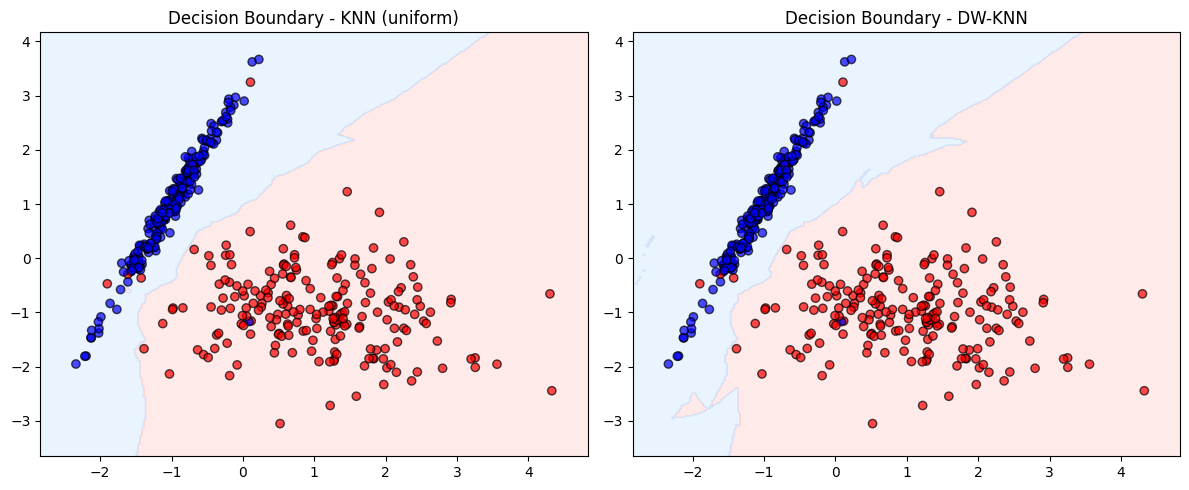

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X_vis, y_vis = make_classification(
    n_samples=600,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=7,
)

X_tr, X_te, y_tr, y_te = train_test_split(X_vis, y_vis, test_size=0.3, stratify=y_vis, random_state=7)

knn_vis = KNeighborsClassifier(n_neighbors=5, weights="uniform")
dw_vis = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")

knn_vis.fit(X_tr, y_tr)
dw_vis.fit(X_tr, y_tr)

# Grid for plotting
x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]

Z_knn = knn_vis.predict(grid).reshape(xx.shape)
Z_dw = dw_vis.predict(grid).reshape(xx.shape)

cmap_bg = ListedColormap(["#FFCCCC", "#CCE5FF"])
cmap_pts = ListedColormap(["#FF0000", "#0000FF"])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_knn, alpha=0.4, cmap=cmap_bg)
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=cmap_pts, edgecolor="k", alpha=0.7)
plt.title("Decision Boundary - KNN (uniform)")

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_dw, alpha=0.4, cmap=cmap_bg)
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=cmap_pts, edgecolor="k", alpha=0.7)
plt.title("Decision Boundary - DW-KNN")

plt.tight_layout()
plt.show()


## 7. Score Reliability & Calibration

We compare probability calibration for KNN (uniform) and DW-KNN on Breast Cancer using reliability diagrams.


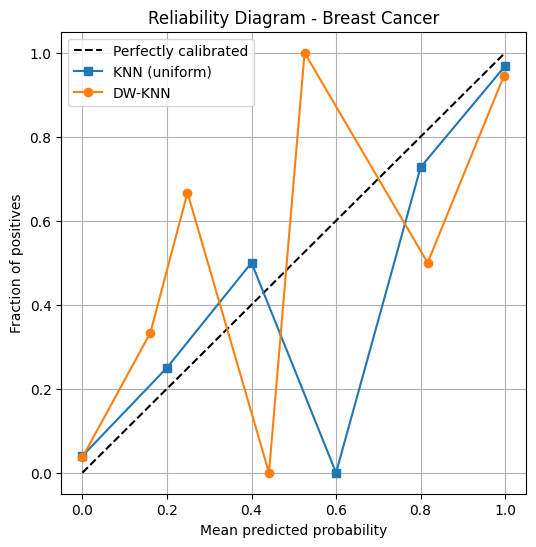

In [50]:
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_tr, X_te, y_tr, y_te = train_test_split(X_bc, y_bc, test_size=0.3, stratify=y_bc, random_state=123)

knn_cal = KNeighborsClassifier(n_neighbors=5, weights="uniform")
dw_cal = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")

knn_cal.fit(X_tr, y_tr)
dw_cal.fit(X_tr, y_tr)

prob_knn = knn_cal.predict_proba(X_te)[:, 1]
prob_dw = dw_cal.predict_proba(X_te)[:, 1]

frac_pos_knn, mean_pred_knn = calibration_curve(y_te, prob_knn, n_bins=10, strategy="uniform")
frac_pos_dw, mean_pred_dw = calibration_curve(y_te, prob_dw, n_bins=10, strategy="uniform")

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.plot(mean_pred_knn, frac_pos_knn, "s-", label="KNN (uniform)")
plt.plot(mean_pred_dw, frac_pos_dw, "o-", label="DW-KNN")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram - Breast Cancer")
plt.legend()
plt.grid(True)
plt.show()


## 8. Retrieval / Drift-Inspired Mini Experiment

We simulate a simple retrieval scenario in a 2D embedding space. A cluster of points represents relevant documents; another shifted cluster mimics *drifted* or *off-topic* documents. DW-KNN validity is used to flag unreliable neighbors.


Query point: [ 0.2 -0.1]
Predicted proba [relevant, drifted]: [1. 0.]
Neighbor index	distance	label	validity
0	0.0574	0	1.0000
54	0.0949	0	1.0000
25	0.1000	0	1.0000
38	0.1641	0	1.0000
49	0.1982	0	1.0000


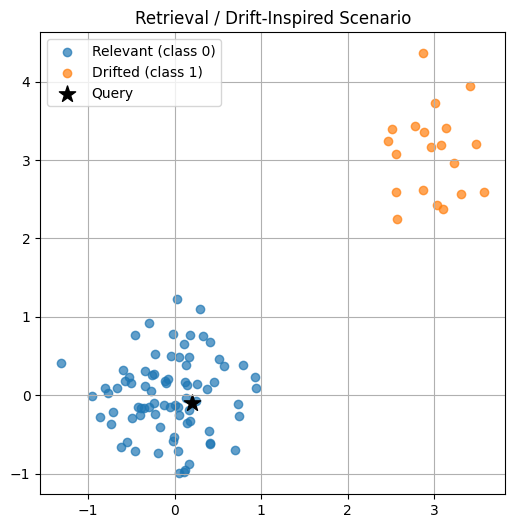

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate "clean" and "drifted" embeddings
rng = np.random.RandomState(42)
clean = rng.normal(loc=[0, 0], scale=0.5, size=(80, 2))
drifted = rng.normal(loc=[3, 3], scale=0.5, size=(20, 2))

X_ret = np.vstack([clean, drifted])
y_ret = np.array([0] * len(clean) + [1] * len(drifted))  # 0=relevant, 1=drifted

# Treat this as labeled data for DW-KNN validity
dw_ret = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")
dw_ret.fit(X_ret, y_ret)

# Query near the relevant cluster center
q = np.array([[0.2, -0.1]])
probs_q = dw_ret.predict_proba(q)[0]

# Inspect neighbors and their validity - FIXED
distances, indices = dw_ret.nn_query_.kneighbors(q, n_neighbors=dw_ret.n_neighbors)
distances = distances[0]
indices = indices[0]

print("Query point:", q[0])
print("Predicted proba [relevant, drifted]:", probs_q)
print("Neighbor index\tdistance\tlabel\tvalidity")
for d, j in zip(distances, indices):
    print(f"{j}\t{d:.4f}\t{y_ret[j]}\t{dw_ret.validity_[j]:.4f}")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(clean[:, 0], clean[:, 1], c="C0", label="Relevant (class 0)", alpha=0.7)
plt.scatter(drifted[:, 0], drifted[:, 1], c="C1", label="Drifted (class 1)", alpha=0.7)
plt.scatter(q[0, 0], q[0, 1], c="k", marker="*", s=150, label="Query")
plt.legend()
plt.title("Retrieval / Drift-Inspired Scenario")
plt.grid(True)
plt.show()


## 9. Failure Case Analysis

Finally, we construct a synthetic dataset where both KNN and DW-KNN struggle (e.g., highly overlapping XOR-like pattern). We compare their errors and inspect DW-KNN explanations to understand why it fails.


In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# XOR-like dataset
X_xor = np.vstack([
    np.random.normal(loc=[-1, -1], scale=0.4, size=(100, 2)),
    np.random.normal(loc=[1, 1], scale=0.4, size=(100, 2)),
    np.random.normal(loc=[-1, 1], scale=0.4, size=(100, 2)),
    np.random.normal(loc=[1, -1], scale=0.4, size=(100, 2)),
])
y_xor = np.array([0] * 200 + [1] * 200)

X_tr, X_te, y_tr, y_te = train_test_split(X_xor, y_xor, test_size=0.3, stratify=y_xor, random_state=0)

knn_fail = KNeighborsClassifier(n_neighbors=5, weights="uniform")
dw_fail = DoubleWeightedKNNClassifier(n_neighbors=5, n_validity_neighbors=10, weight_function="min")

knn_fail.fit(X_tr, y_tr)
dw_fail.fit(X_tr, y_tr)

y_pred_knn = knn_fail.predict(X_te)
y_pred_dw = dw_fail.predict(X_te)

print("Failure-case XOR-like dataset:")
print("  KNN accuracy:   ", accuracy_score(y_te, y_pred_knn))
print("  DW-KNN accuracy:", accuracy_score(y_te, y_pred_dw))

# Inspect a misclassified point by DW-KNN
mis_idx = np.where(y_pred_dw != y_te)[0]
if len(mis_idx) > 0:
    i = mis_idx[0]
    xq = X_te[i].reshape(1, -1)
    print("\nExample misclassified point:")
    print("True label:", y_te[i], "Predicted:", y_pred_dw[i])

    # FIXED: use nn_query_ and n_neighbors
    distances, indices = dw_fail.nn_query_.kneighbors(xq, n_neighbors=dw_fail.n_neighbors)
    distances = distances[0]
    indices = indices[0]

    print("neighbor_index\tdistance\tlabel\tvalidity")
    for d, j in zip(distances, indices):
        print(f"{j}\t{d:.4f}\t{y_tr[j]}\t{dw_fail.validity_[j]:.4f}")
else:
    print("DW-KNN did not misclassify any point in this particular split (try changing random_state).")

Failure-case XOR-like dataset:
  KNN accuracy:    0.9833333333333333
  DW-KNN accuracy: 0.9833333333333333

Example misclassified point:
True label: 1 Predicted: 0
neighbor_index	distance	label	validity
23	0.1253	0	0.9000
6	0.2761	0	1.0000
230	0.3726	0	1.0000
56	0.3756	0	0.9000
229	0.4587	0	1.0000
